In [1]:
import tensorflow as tf
import torch
import numpy as np
Hc = 3
Wc = 4
coord_cells = tf.stack(tf.meshgrid(tf.range(Hc), tf.range(Wc), indexing='ij'), axis=-1)
a = tf.Session().run(coord_cells)

print(a)

import torch
coor_cells = torch.stack(torch.meshgrid(torch.arange(Hc), torch.arange(Wc)), dim=2) # [Hc, Wc, 2]
b = coor_cells.numpy()

print(b)

[[[0 0]
  [0 1]
  [0 2]
  [0 3]]

 [[1 0]
  [1 1]
  [1 2]
  [1 3]]

 [[2 0]
  [2 1]
  [2 2]
  [2 3]]]
[[[0 0]
  [0 1]
  [0 2]
  [0 3]]

 [[1 0]
  [1 1]
  [1 2]
  [1 3]]

 [[2 0]
  [2 1]
  [2 2]
  [2 3]]]


In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import matplotlib.pyplot as plt
os.chdir('../')
print(os.getcwd())

/home/yoyee/Documents/deepSfm


In [3]:
# from utils.utils import warp_points_np
def warp_points_np(points, homographies, device='cpu'):
    """
    Warp a list of points with the given homography.

    Arguments:
        points: list of N points, shape (N, 2).
        homography: batched or not (shapes (B, 3, 3) and (...) respectively).

    Returns: a Tensor of shape (N, 2) or (B, N, 2) (depending on whether the homography
            is batched) containing the new coordinates of the warped points.
    """
    # expand points len to (x, y, 1)
    batch_size = homographies.shape[0]
    points = np.concatenate((points, np.ones((points.shape[0], 1))), axis=1)
    # points = points.to(device)
    # homographies = homographies.(batch_size*3,3)
    # warped_points = homographies*points
    # warped_points = homographies@points.transpose(0,1)
    warped_points = np.tensordot(homographies, points.transpose(), axes=([2], [0]))
    # normalize the points
    warped_points = warped_points.reshape([batch_size, 3, -1])
    warped_points = warped_points.transpose([0, 2, 1])
    warped_points = warped_points[:, :, :2] / warped_points[:, :, 2:]
    return warped_points


def plot_points(matrix, ls='--', lw=1.2, colors=None):
    x_points, y_points = matrix[:,0], matrix[:,1]
    size = len(x_points)
    colors = ['red', 'blue', 'orange', 'green'] if not None else colors
    for i in range(size):
        plt.plot(x_points[i], y_points[i], color=colors[i], marker='o')
        # plt.plot(x_points[i], x_points[(i+1) % size],color=colors[i],linestyle=ls, linewidth=lw)
        # plt.plot(x_points[i], x_points[(i + 1) % size], linestyle=ls, linewidth=lw)
        # [y_points[i], y_points[(i+1) % size]],
                 # color=colors[i],
                 # linestyle=ls, linewidth=lw)

def printCorners(corner_img, mat_homographies):
    points = warp_points_np(corner_img, mat_homographies)
    # plot
    plot_points(corner_img)
    for i in range(points.shape[0]):
        plot_points(points[i,:,:])

def test_sample_homography():
    import cv2
    batch_size = 10
    filename = '../configs/superpoint_coco_train.yaml'
    import yaml
    with open(filename, 'r') as f:
        config = yaml.load(f)
    test_tf = False
    test_corner_def = True

    if test_tf == True:
        from utils.homographies import sample_homography as sample_homography
        boundary = 1
#         from utils.homographies import sample_homography_np as sample_homography
        # mat_homographies = matrix[np.newaxis, :,:]
        # mat_homographies = [sample_homography(tf.constant([boundary,boundary]),
        mat_homographies = [sample_homography(np.array([boundary,boundary]),
                                              **config['data']['warped_pair']['params']) for i in range(batch_size)]
        mat_homographies = np.stack(mat_homographies, axis=0)
        corner_img = np.array([[0., 0.], [0., boundary], [boundary, boundary], [boundary, 0.]])
        printCorners(corner_img, mat_homographies)
        plt.show()
        print("try inverse")
        mat_homographies = np.stack(mat_homographies, axis=0)
        inv_homographies = np.stack([np.linalg.inv(mat_homographies[i, :, :]) for i in range(mat_homographies.shape[0])])
        printCorners(corner_img, inv_homographies)
        plt.show()

    if test_corner_def:
        corner_img = np.array([(-1, -1), (-1, 1), (1, 1), (1, -1)])
        offset = 1
        corner_img += offset
        from utils.homographies import sample_homography_np as sample_homography
        boundary = 2
        mat_homographies = [sample_homography(np.array([boundary,boundary]), shift=-1 + offset,
                                              **config['data']['warped_pair']['params']) for i in range(batch_size)]
        mat_homographies = np.stack(mat_homographies, axis=0)
        
        img = np.zeros((512,512,3), np.uint8)
        points = warp_points_np(corner_img, mat_homographies)
        
        
        # draw polygon
        img = np.zeros((10,10,3), np.uint8)
        points_plt = points.astype(int)
#         print("points: ", points_plt)
#         img_poly = cv2.polylines(img,[points_plt[:1,:,:]],True,(0,255,255))
        

        points = np.array([(-1, -1), (-1, 1), (1, 1), (1, -1)])
        points = points.reshape(-1,4,2)
#         img_poly = cv2.polylines(img,[points],True,(0,255,255))
#         img_poly = cv2.polylines(img,[points[:1,:,:]],True,(0,255,255))

        print("shape", img.shape)
        plt.imshow(img_poly)
        plt.show()
        
        points = points.reshape(-1,4,2)
#         cv2.polylines(img,[points],True,(0,255,255))
#         printCorners(corner_img, mat_homographies)
        plt.imshow(img)

        print("try inverse")
        mat_homographies = np.stack(mat_homographies, axis=0)
        inv_homographies = np.stack([np.linalg.inv(mat_homographies[i, :, :]) for i in range(mat_homographies.shape[0])])
        printCorners(corner_img, inv_homographies)
        plt.show()
        

    else:
        from utils.utils import sample_homography
        mat_homographies = [sample_homography(1) for i in range(batch_size)]

    print("end")
# test_sample_homography()

In [5]:
# test homography with size(240, 360)

import cv2
batch_size = 10
def loadConfig(filename):
    import yaml
    with open(filename, 'r') as f:
        config = yaml.load(f)
    return config
test_tf = False
test_corner_def = True

def scale_homography(H, shape, shift=(-1,-1)):
    height, width = shape[0], shape[1]
    trans = np.array([[2./width, 0., shift[0]], [0., 2./height, shift[1]], [0., 0., 1.]])
    H_tf = np.linalg.inv(trans) @ H @ trans
    return H_tf

def sample_homography_batches(config, batch_size=1, shape=np.array([1,1]), tf=False):
    offset = 0
    b = 2

    if tf:
        from utils.homographies import sample_homography as sample_homography
#         shape = np.array([b, b])
        mat_homographies = [sample_homography(shape,
                                          **config['data']['warped_pair']['params']) for i in range(batch_size)]
        
#         mat_homographies = [scale_homography(sample_homography(shape,
#                                           **config['data']['warped_pair']['params']), shape)
#                                             for i in range(batch_size)]
    else:
        from utils.homographies import sample_homography_np as sample_homography
        mat_homographies = [sample_homography(shape, shift=-1 + offset,
                                          **config['data']['warped_pair']['params']) for i in range(batch_size)]
    
    mat_homographies = np.stack(mat_homographies, axis=0)
    return mat_homographies



def drawBox(points, img, offset=np.array([0,0]), color=(0,255,0)):
#     print("origin", points)
    offset = offset[::-1]
    points = points + offset    
    points = points.astype(int)
    for i in range(len(points)):
        img = img + cv2.line(np.zeros_like(img),tuple(points[-1+i]), tuple(points[i]), color,5)
    return img

# load config
# filename = '../configs/config_test.yaml'
# config = loadConfig(filename)

In [6]:
height, width = 240, 320
corner_img = np.array([(0, 0), (height, 0), (height, width), (0, width)])
offset = np.array([1,5])
print(corner_img + offset)

[[  1   5]
 [241   5]
 [241 325]
 [  1 325]]


['homographies', 'masks']
[[ 0.8047 -0.0251 -0.0003]
 [-0.0125  0.919  -0.0549]
 [ 0.0151 -0.0258  1.    ]]


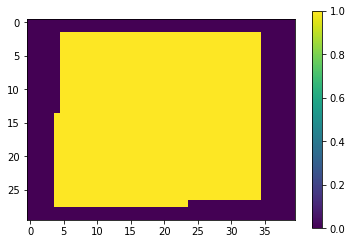

In [8]:
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import matplotlib.pyplot as plt

import numpy as np
a = np.load('notebooks/h2.npz')
print(list(a))
H = np.squeeze(a['homographies'])
print(H)
Ms = np.squeeze(a['masks'])

plt.imshow(Ms)
plt.colorbar()
plt.show()

In [9]:
def test_valid_mask():
    import os
    import sys
    module_path = os.path.abspath(os.path.join('..'))
    if module_path not in sys.path:
        sys.path.append(module_path)
    from utils.utils import pltImshow
#     from utils.homographies import sample_homography as sample_homography
    from utils.utils import sample_homography

    batch_size = 1
    
    mat_homographies = [sample_homography(3) for i in range(batch_size)]
    mat_H = np.stack(mat_homographies, axis=0)


    corner_img = np.array([(-1, -1), (-1, 1), (1, -1), (1, 1)])
    # printCorners(corner_img, mat_H)
    # points = warp_points_np(corner_img, mat_homographies)

    mat_H = torch.tensor(mat_H, dtype=torch.float32)
    mat_H_inv = torch.stack([torch.inverse(mat_H[i, :, :]) for i in range(batch_size)])
    from utils.utils import compute_valid_mask, labels2Dto3D
    device = 'cpu'
    shape = torch.tensor([240, 320])
    for i in range(1):
        r = 3
        mask_valid = compute_valid_mask(shape, inv_homography=mat_H_inv, device=device, erosion_radius=r)
        pltImshow(mask_valid[0,:,:])
        cell_size = 8
        mask_valid = labels2Dto3D(mask_valid.view(batch_size, 1, mask_valid.shape[1], mask_valid.shape[2]), cell_size=cell_size)
        mask_valid = torch.prod(mask_valid[:,:cell_size*cell_size,:,:], dim=1)
        pltImshow(mask_valid[0,:,:].cpu().numpy())
        plt.show()

    mask = {}
    mask.update({'homographies': mat_H, 'masks': mask_valid})
    np.savez_compressed('h2.npz', **mask)
    print("finish testing valid mask")
    return mat_H


In [10]:
def my_valid_mask(mat_H):
    from utils.utils import compute_valid_mask, labels2Dto3D
    from utils.utils import pltImshow
    
        
    r = 3
    shape = torch.tensor([240, 320])
    device = 'cpu'
    mat_H_inv = torch.inverse(mat_H).unsqueeze(dim=0)
    mask_valid = compute_valid_mask(shape, inv_homography=mat_H_inv, device=device, erosion_radius=r)
    pltImshow(mask_valid[0,:,:])
    cell_size = 8
    mask_valid = labels2Dto3D(mask_valid.view(1, 1, mask_valid.shape[1], mask_valid.shape[2]), cell_size=cell_size)
    mask_valid = torch.prod(mask_valid[:,:cell_size*cell_size,:,:], dim=1)
    pltImshow(mask_valid[0,:,:].cpu().numpy())
    plt.show()

    mask = {}
    mask.update({'homographies': mat_H, 'masks': mask_valid})
    np.savez_compressed('h2.npz', **mask)
    print("finish testing valid mask")
    return mat_H

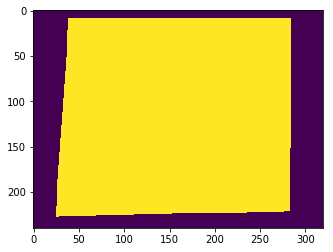

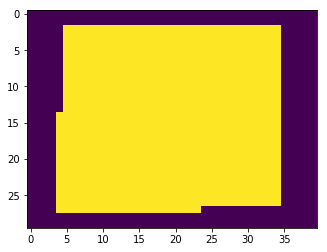

finish testing valid mask
Homography: [[ 0.8047 -0.0251 -0.0003]
 [-0.0125  0.919  -0.0549]
 [ 0.0151 -0.0258  1.    ]]


In [11]:
# H = test_valid_mask()
# H = np.squeeze(a['homographies'])
my_valid_mask(torch.tensor(H))
print('Homography:', H)

[  1.2342   0.0828 -45.5742  -0.002    1.1264  -6.4992  -0.0001   0.0002]
[[  1.2342   0.0828 -45.5742]
 [ -0.002    1.1264  -6.4992]
 [ -0.0001   0.0002   1.    ]]


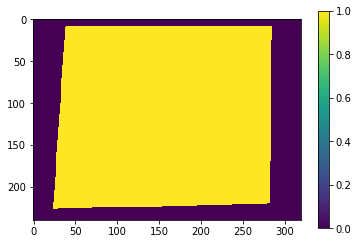

(1, 1, 1, 30, 40)


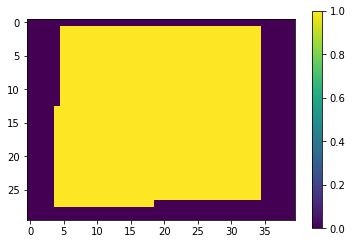

In [12]:
def compute_valid_mask(image_shape, homography, erosion_radius=0):
    """
    Compute a boolean mask of the valid pixels resulting from an homography applied to
    an image of a given shape. Pixels that are False correspond to bordering artifacts.
    A margin can be discarded using erosion.
    Arguments:
        input_shape: Tensor of rank 2 representing the image shape, i.e. `[H, W]`.
        homography: Tensor of shape (B, 8) or (8,), where B is the batch size.
        erosion_radius: radius of the margin to be discarded.
    Returns: a Tensor of type `tf.int32` and shape (H, W).
    """
    mask = H_transform(tf.ones(image_shape), homography, interpolation='NEAREST')
    if erosion_radius > 0:
        kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (erosion_radius*2,)*2)
        mask = tf.nn.erosion2d(
                mask[tf.newaxis, ..., tf.newaxis],
                tf.to_float(tf.constant(kernel)[..., tf.newaxis]),
                [1, 1, 1, 1], [1, 1, 1, 1], 'SAME')[0, ..., 0] + 1.
    return tf.to_int32(mask)

import tensorflow as tf
import cv2 as cv
from tensorflow.contrib.image import transform as H_transform
sess = tf.Session()

Hc = 30
Wc = 40
grid_size = 8
Height = Hc * grid_size
Width = Wc * grid_size
image_shape = tf.constant([Height, Width])
# H = np.array([[1., 1., 0.], [0., 1., 0.], [0., 0., 1.]])
trans = np.array([[2./Width, 0., -1], [0., 2./Height, -1], [0., 0., 1.]])
H_tf = np.linalg.inv(np.linalg.inv(trans) @ H @ trans)
H_tf = H_tf / H_tf[2, 2]
homography = tf.constant(H_tf.reshape(-1)[:8], tf.float32)
# homography = homographysample
print(sess.run(homography))
print(H_tf)

erosion_radius = 3 # from valid_border_margin of https://github.com/rpautrat/SuperPoint/blob/master/superpoint/configs/superpoint_coco.yaml
valid_mask = compute_valid_mask(image_shape, homography, erosion_radius)
mask = sess.run(valid_mask)

plt.imshow(mask)
plt.colorbar()
plt.show()

valid_mask = tf.to_float(valid_mask[tf.newaxis, ..., tf.newaxis])  # for GPU
valid_mask = tf.space_to_depth(valid_mask, grid_size)
valid_mask = tf.reduce_prod(valid_mask, axis=3)  # AND along the channel dim
valid_mask = tf.reshape(valid_mask, [1, 1, 1, Hc, Wc])

mask = sess.run(valid_mask)
print(mask.shape)

plt.imshow(np.squeeze(mask))
plt.colorbar()
plt.show()

In [13]:
np.linalg.inv(trans) @ H @ trans

array([[ 0.8198, -0.0678, 36.9226],
       [ 0.002 ,  0.8933,  5.8966],
       [ 0.0001, -0.0002,  1.0106]])

In [14]:
np.linalg.inv(np.linalg.inv(trans) @ H @ trans)

array([[  1.2248,   0.0821, -45.2256],
       [ -0.002 ,   1.1178,  -6.4494],
       [ -0.0001,   0.0002,   0.9924]])

array([[ 0.0063,  0.    , -1.    ],
       [ 0.    ,  0.0083, -1.    ],
       [ 0.    ,  0.    ,  1.    ]])

In [16]:
from utils.utils import warp_points
def desc_mask(homographies, cell_size=8, device='cpu'):
    from utils.utils import warp_points

    def normPts(pts, shape):
        """
        normalize pts to [-1, 1]
        :param pts:
            tensor (y, x)
        :param shape:
            numpy (y, x)
        :return:
        """
        pts = pts/shape*2 - 1
        return pts

    def denormPts(pts, shape):
        """
        denormalize pts back to H, W
        :param pts:
            tensor (y, x)
        :param shape:
            numpy (y, x)
        :return:
        """
        pts = (pts+1)*shape/2
        return pts
    
    debug = True
    Hc, Wc = 30, 40
    print("homo ", homographies.shape)
    shape = torch.tensor([240, 320]).type(torch.FloatTensor).to(device)
    if debug: print("shape: ", shape)
    # compute the center pixel of every cell in the image
    coor_cells = torch.stack(torch.meshgrid(torch.arange(Hc), torch.arange(Wc)), dim=2)
    if debug: print("coor_cells: ", coor_cells)
    coor_cells = coor_cells.type(torch.FloatTensor).to(device)
    if debug: print("coor_cells: ", coor_cells)
    coor_cells = coor_cells * cell_size + cell_size // 2
    if debug: print("coor_cells: ", coor_cells)
    

    ## coord_cells is now a grid containing the coordinates of the Hc x Wc
    ## center pixels of the 8x8 cells of the image

    # coor_cells = coor_cells.view([-1, Hc, Wc, 1, 1, 2])
    coor_cells = coor_cells.view([-1, 1, 1, Hc, Wc, 2])  # be careful of the order
    if debug: print("coor_cells: ", coor_cells)
    # warped_coor_cells = warp_points(coor_cells.view([-1, 2]), w, device)
    warped_coor_cells = normPts(coor_cells.view([-1, 2]), shape)
    if debug: print("warped_coor_cells: ", warped_coor_cells)
    warped_coor_cells = torch.stack((warped_coor_cells[:,1], warped_coor_cells[:,0]), dim=1) # (y, x) to (x, y)
    if debug: print("warped_coor_cells: ", warped_coor_cells)
    warped_coor_cells = warp_points(warped_coor_cells, homographies, device)
    if debug: print("warped_coor_cells: ", warped_coor_cells)
    print("shape: ", warped_coor_cells.shape)
    warped_coor_cells = torch.stack((warped_coor_cells[:, :, 1], warped_coor_cells[:, :, 0]), dim=2)  # (batch, x, y) to (batch, y, x)
    if debug: print("warped_coor_cells: ", warped_coor_cells)

    shape_cell = torch.tensor([240/cell_size, 320/cell_size]).type(torch.FloatTensor).to(device)
    # warped_coor_mask = denormPts(warped_coor_cells, shape_cell)

    warped_coor_cells = denormPts(warped_coor_cells, shape)
    print("warped: ", warped_coor_cells[0,:10,:])
    # warped_coor_cells = warped_coor_cells.view([-1, 1, 1, Hc, Wc, 2])
    warped_coor_cells = warped_coor_cells.view([-1, Hc, Wc, 1, 1, 2])
#     print("warped_coor_cells: ", warped_coor_cells.shape)
    # compute the pairwise distance
    cell_distances = coor_cells - warped_coor_cells
    if debug: print("cell_distances: ", cell_distances)
    cell_distances = torch.norm(cell_distances, dim=-1)
    if debug: print("cell_distances: ", cell_distances)
    mask = cell_distances <= cell_size - 0.5 # trick
    mask = mask.type(torch.FloatTensor).to(device)
    return mask

mask = desc_mask(torch.tensor(H).unsqueeze(0))

homo  torch.Size([1, 3, 3])
shape:  tensor([240., 320.])
coor_cells:  tensor([[[ 0,  0],
         [ 0,  1],
         [ 0,  2],
         ...,
         [ 0, 37],
         [ 0, 38],
         [ 0, 39]],

        [[ 1,  0],
         [ 1,  1],
         [ 1,  2],
         ...,
         [ 1, 37],
         [ 1, 38],
         [ 1, 39]],

        [[ 2,  0],
         [ 2,  1],
         [ 2,  2],
         ...,
         [ 2, 37],
         [ 2, 38],
         [ 2, 39]],

        ...,

        [[27,  0],
         [27,  1],
         [27,  2],
         ...,
         [27, 37],
         [27, 38],
         [27, 39]],

        [[28,  0],
         [28,  1],
         [28,  2],
         ...,
         [28, 37],
         [28, 38],
         [28, 39]],

        [[29,  0],
         [29,  1],
         [29,  2],
         ...,
         [29, 37],
         [29, 38],
         [29, 39]]])
coor_cells:  tensor([[[ 0.,  0.],
         [ 0.,  1.],
         [ 0.,  2.],
         ...,
         [ 0., 37.],
         [ 0., 38.],
    

mask shape torch.Size([1, 30, 40, 30, 40])
(30, 40)
the correspondence of ( 0 0 ) in image 1. [ 0 0 :,:]


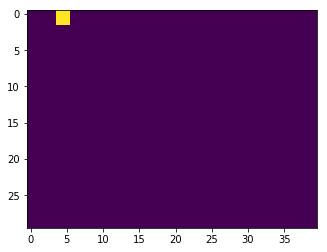

(30, 40)
the correspondence of ( 29 39 ) in image 1. [ 29 39 :,:]


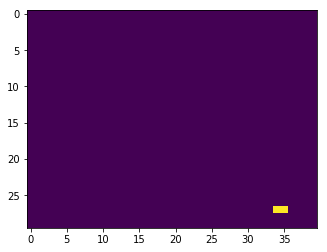

(30, 40)
the correspondence of ( 29 0 ) in image 1. [ 29 0 :,:]


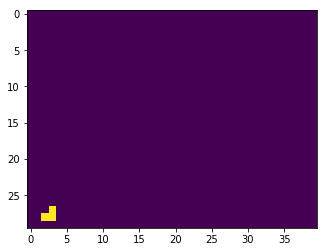

(30, 40)
the correspondence of ( 0 39 ) in image 1. [ 0 39 :,:]


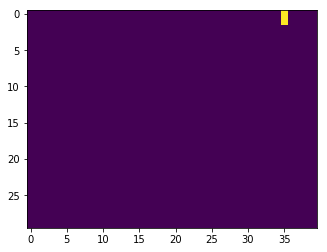

(30, 40)
the correspondence of ( 15 20 ) in image 1. [ 15 20 :,:]


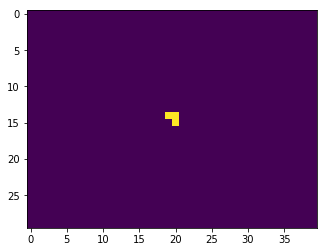

sum up dim1 and dim2. should look like warping


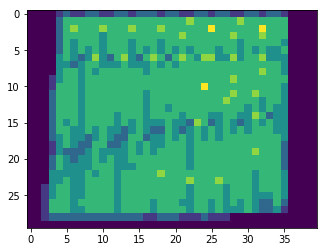

(30, 40)
the correspondence of '0,0', in warped image. [30,40,y,x]


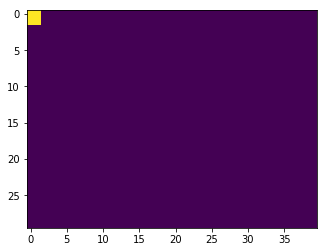

sum up dim3 and dim4. should look like all ones


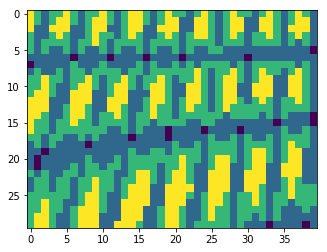

In [35]:
print("mask shape", mask.shape)
from utils.utils import pltImshow
mask_o = mask.cpu().numpy()
y, x = 0, 0
height, width = 30, 40
def plot_mask_corr(mask, y,x):
    img = mask[0,y,x,:,:]
    print(img.shape)
    print("the correspondence of (",y,x,") in image 1. [",y,x,":,:]")
    pltImshow(img)
plot_mask_corr(mask_o, 0,0)
plot_mask_corr(mask_o, height-1,width-1)
plot_mask_corr(mask_o, height-1,0)
plot_mask_corr(mask_o, 0,width-1)
plot_mask_corr(mask_o, height//2,width//2)
# 
mask_o = mask.sum(dim=1).sum(dim=1)
img = (mask_o).cpu().numpy()[0,:,:]
print("sum up dim1 and dim2. should look like warping")

pltImshow(img)
# 
y, x = 1, 5
img = (mask).cpu().numpy()[0,:,:,y,x]
print(img.shape)
print("the correspondence of '0,0', in warped image. [30,40,y,x]")
pltImshow(img)

# 
mask_o = mask.sum(dim=3).sum(dim=3)
img = (mask_o).cpu().numpy()[0,:,:]
print("sum up dim3 and dim4. should look like all ones")

pltImshow(img)

In [18]:
def loadConfig(filename):
    import yaml
    with open(filename, 'r') as f:
        config = yaml.load(f)
    return config


In [19]:
# load config
# logging.basicConfig(format='[%(asctime)s %(levelname)s] %(message)s',
#                         datefmt='%m/%d/%Y %H:%M:%S', level=logging.INFO)


filename = 'configs/superpoint_coco_test.yaml'
# filename = 'configs/magicpoint_repeatability.yaml'
config = loadConfig(filename)
print("config path: ", filename)
print("config: ", config)

config path:  configs/superpoint_coco_test.yaml
config:  {'data': {'name': 'coco', 'dataset': 'coco', 'labels': 'magicpoint_synth20_homoAdapt100_coco/predictions', 'cache_in_memory': False, 'validation_size': 10, 'preprocessing': {'resize': [240, 320]}, 'augmentation': {'photometric': {'enable': True, 'primitives': ['random_brightness', 'random_contrast', 'additive_speckle_noise', 'additive_gaussian_noise', 'additive_shade', 'motion_blur'], 'params': {'random_brightness': {'max_abs_change': 50}, 'random_contrast': {'strength_range': [0.5, 1.5]}, 'additive_gaussian_noise': {'stddev_range': [0, 10]}, 'additive_speckle_noise': {'prob_range': [0, 0.0035]}, 'additive_shade': {'transparency_range': [-0.5, 0.5], 'kernel_size_range': [100, 150]}, 'motion_blur': {'max_kernel_size': 3}}}, 'homographic': {'enable': False}}, 'warped_pair': {'enable': True, 'params': {'translation': True, 'rotation': True, 'scaling': True, 'perspective': True, 'scaling_amplitude': 0.2, 'perspective_amplitude_x': 0.

## descriptor_loss my implementation

In [20]:
## random data
np.random.seed(seed=0)
descriptors_np = np.random.rand(1,30,40,256).astype('float32')
warped_descriptors_np = np.random.rand(1,30,40,256).astype('float32')


In [70]:
# sample homography
def sample_homography_batches(config, batch_size=1, shape=np.array([1,1]), tf=False):
    offset = 0
    b = 2

    if tf:
        from utils.homographies import sample_homography as sample_homography
#         shape = np.array([b, b])
        mat_homographies = [sample_homography(shape,
                                          **config['data']['augmentation']['homographic']['params']) for i in range(batch_size)]
        
#         mat_homographies = [scale_homography(sample_homography(shape,
#                                           **config['data']['warped_pair']['params']), shape)
#                                             for i in range(batch_size)]
    else:
        from utils.homographies import sample_homography_np as sample_homography
        mat_homographies = [sample_homography(shape, shift=-1 + offset,
                                          **config['data']['warped_pair']['params']) for i in range(batch_size)]
    
    mat_homographies = np.stack(mat_homographies, axis=0)
    return mat_homographies

# homographies = sample_homography_batches(config, shape = np.array([2,2]))
homographies = sample_homography_batches(config, batch_size=1, shape=np.array([2,2]), tf=False)

print("homographies: ", homographies)


homographies:  [[[ 0.6867 -0.4182  0.1464]
  [ 0.3948  0.7248  0.0734]
  [ 0.1248  0.      1.    ]]]


homography visualization for my inplementation
print forward homographies


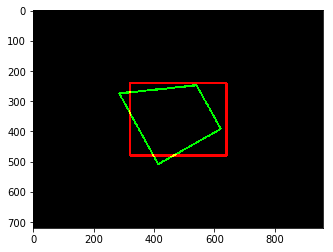

print inverse homographies


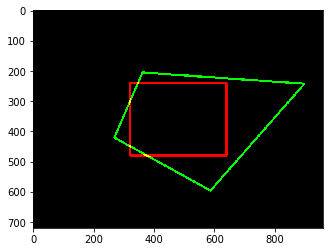

In [97]:
# homography visualization for my inplementation
print("homography visualization for my inplementation")


from numpy.linalg import inv

# sample homography
batch_size = 1
shape = np.array([2,2])
homographies = sample_homography_batches(config, batch_size, shape=shape, tf=False)
homographies_original = homographies.copy()

# change shapes
height, width = 240, 320
image_shape = np.array([height, width])
homographies = np.stack([scale_homography(H, image_shape, shift=(-1,-1)) for H in homographies])

# warp points
# from utils.utils import warp_points_np
# corner_img = np.array([(0, 0), (height, 0), (height, width), (0, width)])
corner_img = np.array([(0, 0), (0, height), (width, height), (width, 0)])
points = warp_points_np(corner_img, homographies)

# plot shapes
offset = np.array([height,width])
img = np.zeros((height + offset[0]*2, width + offset[1]*2,3), np.uint8)
img = drawBox(corner_img, img, color=(255,0,0), offset=offset)
for i in range(points.shape[0]):
    img = drawBox(points[i,:,:], img, color=(0,255,0), offset=offset)
print("print forward homographies")
plt.imshow(img)
plt.show()

#  inv_homography
inv_homographies = np.stack([inv(H) for H in homographies])

# warp points
# from utils.utils import warp_points_np
# corner_img = np.array([(0, 0), (height, 0), (height, width), (0, width)])
corner_img = np.array([(0, 0), (0, height), (width, height), (width, 0)])
points = warp_points_np(corner_img, inv_homographies)

# plot shapes
offset = np.array([height,width])
img = np.zeros((height + offset[0]*2, width + offset[1]*2,3), np.uint8)
img = drawBox(corner_img, img, color=(255,0,0), offset=offset)
for i in range(points.shape[0]):
    img = drawBox(points[i,:,:], img, color=(0,255,0), offset=offset)
    
print("print inverse homographies")
plt.imshow(img)

plt.show()


In [98]:
# H = inv_homographies.squeeze().astype('float32')
# print("We use inverse homography!")
H = homographies_original.squeeze().astype('float32')
print("We use forward homography!")
print("homography: ", H)

We use forward homography!
homography:  [[ 0.7032  0.3074  0.0833]
 [-0.3063  0.7425 -0.0984]
 [ 0.2382 -0.      1.    ]]


In [99]:
def descriptor_loss(descriptors, descriptors_warped, homographies, mask_valid=None, 
                    cell_size=8, lamda_d=250, device='cpu', descriptor_dist=4, **config):
    '''
    Compute descriptor loss from descriptors_warped and given homographies

    :param descriptors:
        Output from descriptor head
        tensor [batch_size, descriptors, Hc, Wc]
    :param descriptors_warped:
        Output from descriptor head of warped image
        tensor [batch_size, descriptors, Hc, Wc]
    :param homographies:
        known homographies
    :param cell_size:
        8
    :param device:
        gpu or cpu
    :param config:
    :return:
        loss, and other tensors for visualization
    '''
    def normPts(pts, shape):
        """
        normalize pts to [-1, 1]
        :param pts:
            tensor (y, x)
        :param shape:
            numpy (y, x)
        :return:
        """
        pts = pts/shape*2 - 1
        return pts

    def denormPts(pts, shape):
        """
        denormalize pts back to H, W
        :param pts:
            tensor (y, x)
        :param shape:
            numpy (y, x)
        :return:
        """
        pts = (pts+1)*shape/2
        return pts
    # config
    from utils.utils import warp_points
    lamda_d = lamda_d # 250
    margin_pos = 1
    margin_neg = 0.2
    batch_size, Hc, Wc = descriptors.shape[0], descriptors.shape[2], descriptors.shape[3]
    #####
#     H, W = Hc.numpy().astype(int) * cell_size, Wc.numpy().astype(int) * cell_size
    H, W = Hc * cell_size, Wc * cell_size
    #####
    # shape = torch.tensor(list(descriptors.shape[2:]))*torch.tensor([cell_size, cell_size]).type(torch.FloatTensor).to(device)
    shape = torch.tensor([H, W]).type(torch.FloatTensor).to(device)
    # compute the center pixel of every cell in the image
    coor_cells = torch.stack(torch.meshgrid(torch.arange(Hc), torch.arange(Wc)), dim=2)
    coor_cells = coor_cells.type(torch.FloatTensor).to(device)
    coor_cells = coor_cells * cell_size + cell_size // 2
    ## coord_cells is now a grid containing the coordinates of the Hc x Wc
    ## center pixels of the 8x8 cells of the image

    # coor_cells = coor_cells.view([-1, Hc, Wc, 1, 1, 2])
    coor_cells = coor_cells.view([-1, 1, 1, Hc, Wc, 2])  # be careful of the order
    # warped_coor_cells = warp_points(coor_cells.view([-1, 2]), homographies, device)
    warped_coor_cells = normPts(coor_cells.view([-1, 2]), shape)
    warped_coor_cells = torch.stack((warped_coor_cells[:,1], warped_coor_cells[:,0]), dim=1) # (y, x) to (x, y)
    warped_coor_cells = warp_points(warped_coor_cells, homographies, device)

    warped_coor_cells = torch.stack((warped_coor_cells[:, :, 1], warped_coor_cells[:, :, 0]), dim=2)  # (batch, x, y) to (batch, y, x)

    shape_cell = torch.tensor([H//cell_size, W//cell_size]).type(torch.FloatTensor).to(device)
    # warped_coor_mask = denormPts(warped_coor_cells, shape_cell)

    warped_coor_cells = denormPts(warped_coor_cells, shape)
    # warped_coor_cells = warped_coor_cells.view([-1, 1, 1, Hc, Wc, 2])
    warped_coor_cells = warped_coor_cells.view([-1, Hc, Wc, 1, 1, 2])
#     print("warped_coor_cells: ", warped_coor_cells.shape)
    # compute the pairwise distance
    cell_distances = coor_cells - warped_coor_cells
    cell_distances = torch.norm(cell_distances, dim=-1)
    ##### check
#     print("descriptor_dist: ", descriptor_dist)
    mask = cell_distances <= descriptor_dist # 0.5 # trick
    mask = mask.type(torch.FloatTensor).to(device)

    # compute the pairwise dot product between descriptors: d^t * d
    descriptors = descriptors.transpose(1, 2).transpose(2, 3)
    descriptors = descriptors.view((batch_size, Hc, Wc, 1, 1, -1))
    descriptors_warped = descriptors_warped.transpose(1, 2).transpose(2, 3)
    descriptors_warped = descriptors_warped.view((batch_size, 1, 1, Hc, Wc, -1))
    dot_product_desc = descriptors * descriptors_warped
    dot_product_desc = dot_product_desc.sum(dim=-1)
    ## dot_product_desc.shape = [batch_size, Hc, Wc, Hc, Wc, desc_len]

    # hinge loss
    positive_dist = torch.max(margin_pos - dot_product_desc, torch.tensor(0.).to(device))
    # positive_dist[positive_dist < 0] = 0
    negative_dist = torch.max(dot_product_desc - margin_neg, torch.tensor(0.).to(device))
    # negative_dist[negative_dist < 0] = 0
    # sum of the dimension

    if mask_valid is None:
#         mask_valid = torch.ones_like(mask)
        mask_valid = torch.ones(batch_size, 1, Hc, Wc)
    mask_valid = mask_valid.view(batch_size, 1, 1, mask_valid.shape[2], mask_valid.shape[3])
    print("mask_valid: ", mask_valid.shape)

    loss_desc = lamda_d * mask * positive_dist + (1 - mask) * negative_dist
    print("loss_desc: ", loss_desc.shape)
    loss_desc = loss_desc * mask_valid
    
#         mask_valid = torch.ones_like(mask)
    normalization = (batch_size * (mask_valid.sum()) * Hc * Wc)
    pos_sum = (lamda_d * mask * positive_dist/normalization).sum()
    neg_sum = ((1 - mask) * negative_dist/normalization).sum()
    loss_desc = loss_desc.sum() / normalization
    # loss_desc = loss_desc.sum() / (batch_size * Hc * Wc)
    # return loss_desc, mask, mask_valid, positive_dist, negative_dist
#     return loss_desc, mask, pos_sum, neg_sum
    return {'loss': loss_desc, 'normalization': normalization, 
            'pos_sum': pos_sum, 'neg_sum': neg_sum, 'mask': mask}
    


In [100]:
homographies = torch.tensor(H[np.newaxis,:,:])
descriptors_torch = torch.tensor(descriptors_np.transpose([0,3,1,2]))
warped_descriptors_torch = torch.tensor(warped_descriptors_np.transpose([0,3,1,2]))
losses = descriptor_loss(descriptors_torch, warped_descriptors_torch, homographies, 
                         descriptor_dist=7.5, mask_valid=None)
for e in losses:
    print(e, ': ', losses[e])



mask_valid:  torch.Size([1, 1, 1, 30, 40])
loss_desc:  torch.Size([1, 30, 40, 30, 40])
loss :  tensor(63.6282)
normalization :  tensor(1440000.)
pos_sum :  tensor(0.)
neg_sum :  tensor(63.6283)
mask :  tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0.,

(30, 40)
the correspondence of ( 0 0 ) in image 1. [ 0 0 :,:]


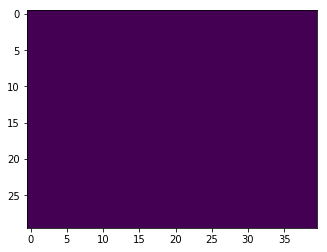

(30, 40)
the correspondence of ( 29 39 ) in image 1. [ 29 39 :,:]


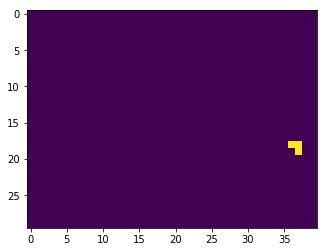

(30, 40)
the correspondence of ( 29 0 ) in image 1. [ 29 0 :,:]


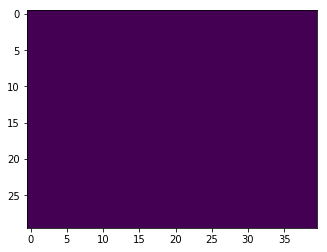

(30, 40)
the correspondence of ( 0 39 ) in image 1. [ 0 39 :,:]


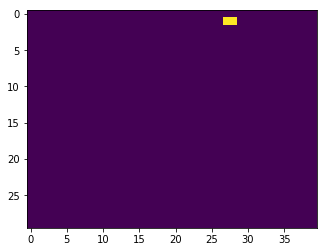

(30, 40)
the correspondence of ( 15 20 ) in image 1. [ 15 20 :,:]


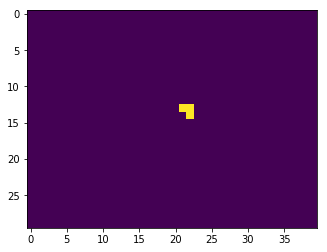

In [101]:
# visualization
mask = losses['mask']
mask_o = mask.cpu().numpy()
y, x = 0, 0
height, width = 30, 40
plot_mask_corr(mask_o, 0,0)
plot_mask_corr(mask_o, height-1,width-1)
plot_mask_corr(mask_o, height-1,0)
plot_mask_corr(mask_o, 0,width-1)
plot_mask_corr(mask_o, height//2,width//2)

sum up dim1 and dim2. should look like warping


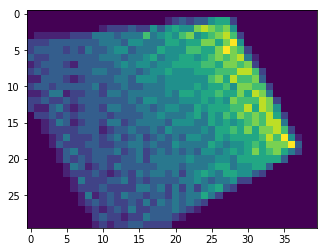

(30, 40)
the correspondence of '0,0', in warped image. [30,40,y,x]


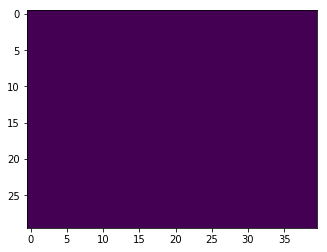

sum up dim3 and dim4. should look like all ones


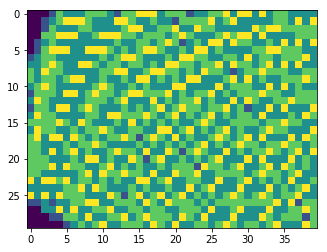

In [102]:
# 
mask_o = mask.sum(dim=1).sum(dim=1)
img = (mask_o).cpu().numpy()[0,:,:]
print("sum up dim1 and dim2. should look like warping")

pltImshow(img)
# 
y, x = 1, 5
img = (mask).cpu().numpy()[0,:,:,y,x]
print(img.shape)
print("the correspondence of '0,0', in warped image. [30,40,y,x]")
pltImshow(img)

# 
mask_o = mask.sum(dim=3).sum(dim=3)
img = (mask_o).cpu().numpy()[0,:,:]
print("sum up dim3 and dim4. should look like all ones")

pltImshow(img)

## descriptor_loss tensorflow

In [103]:
def descriptor_loss(descriptors, warped_descriptors, homographies,
                    valid_mask=None, **config):
    from models.homographies import warp_points
    # Compute the position of the center pixel of every cell in the image
    (batch_size, Hc, Wc) = tf.unstack(tf.to_int32(tf.shape(descriptors)[:3]))
    coord_cells = tf.stack(tf.meshgrid(
        tf.range(Hc), tf.range(Wc), indexing='ij'), axis=-1)
    coord_cells = coord_cells * config['grid_size'] + config['grid_size'] // 2  # (Hc, Wc, 2)
    # coord_cells is now a grid containing the coordinates of the Hc x Wc
    # center pixels of the 8x8 cells of the image

    # Compute the position of the warped center pixels
    warped_coord_cells = warp_points(tf.reshape(coord_cells, [-1, 2]), homographies)
    # warped_coord_cells is now a list of the warped coordinates of all the center
    # pixels of the 8x8 cells of the image, shape (N, Hc x Wc, 2)

    # Compute the pairwise distances and filter the ones less than a threshold
    # The distance is just the pairwise norm of the difference of the two grids
    # Using shape broadcasting, cell_distances has shape (N, Hc, Wc, Hc, Wc)
    coord_cells = tf.to_float(tf.reshape(coord_cells, [1, 1, 1, Hc, Wc, 2]))
    warped_coord_cells = tf.reshape(warped_coord_cells,
                                    [batch_size, Hc, Wc, 1, 1, 2])
    cell_distances = tf.norm(coord_cells - warped_coord_cells, axis=-1)
    margin = 0.5
    print("descriptor loss distance: ", config['grid_size'] - margin)
    s = tf.to_float(tf.less_equal(cell_distances, config['grid_size'] - margin))

    # s[id_batch, h, w, h', w'] == 1 if the point of coordinates (h, w) warped by the
    # homography is at a distance from (h', w') less than config['grid_size']
    # and 0 otherwise

    # Compute the pairwise dot product between descriptors: d^t * d'
    descriptors = tf.reshape(descriptors, [batch_size, Hc, Wc, 1, 1, -1])
    warped_descriptors = tf.reshape(warped_descriptors,
                                    [batch_size, 1, 1, Hc, Wc, -1])
    dot_product_desc = tf.reduce_sum(descriptors * warped_descriptors, -1)
    # dot_product_desc[id_batch, h, w, h', w'] is the dot product between the
    # descriptor at position (h, w) in the original descriptors map and the
    # descriptor at position (h', w') in the warped image

    # Compute the loss
    positive_dist = tf.maximum(0., config['positive_margin'] - dot_product_desc)
    negative_dist = tf.maximum(0., dot_product_desc - config['negative_margin'])
    loss = config['lambda_d'] * s * positive_dist + (1 - s) * negative_dist

    # Mask the pixels if bordering artifacts appear
    valid_mask = tf.ones([batch_size,
                          Hc * config['grid_size'],
                          Wc * config['grid_size']], tf.float32)\
        if valid_mask is None else valid_mask
    valid_mask = tf.to_float(valid_mask[..., tf.newaxis])  # for GPU
    valid_mask = tf.space_to_depth(valid_mask, config['grid_size'])
    valid_mask = tf.reduce_prod(valid_mask, axis=3)  # AND along the channel dim
    valid_mask = tf.reshape(valid_mask, [batch_size, 1, 1, Hc, Wc])

    normalization = tf.reduce_sum(valid_mask) * tf.to_float(Hc * Wc)
    # Summaries for debugging
    # tf.summary.scalar('nb_positive', tf.reduce_sum(valid_mask * s) / normalization)
    # tf.summary.scalar('nb_negative', tf.reduce_sum(valid_mask * (1 - s)) / normalization)
    tf.summary.scalar('positive_dist', tf.reduce_sum(valid_mask * config['lambda_d'] *
                                                     s * positive_dist) / normalization)
    tf.summary.scalar('negative_dist', tf.reduce_sum(valid_mask * (1 - s) *
                                                     negative_dist) / normalization)
    
    pos_sum =  tf.reduce_sum( config['lambda_d'] * s * positive_dist / normalization )
    neg_sum =  tf.reduce_sum( (1 - s) * negative_dist / normalization )
    
    loss = tf.reduce_sum(valid_mask * loss) / normalization
    return {'loss': loss, 'normalization': normalization, 
            'pos_sum': pos_sum, 'neg_sum': neg_sum,
            'mask': s}

config.update({'grid_size': 8})
config.update({'positive_margin': 1})
config.update({'negative_margin': 0.2})
config.update({'lambda_d': 800})

# transform H
def scalingHomography(H, Hc = 30, Wc = 40):
    # Hc = 30
    # Wc = 40
    grid_size = 8
    Height = Hc * grid_size
    Width = Wc * grid_size
    image_shape = tf.constant([Height, Width])
    # H = np.array([[1., 1., 0.], [0., 1., 0.], [0., 0., 1.]])
    trans = np.array([[2./Width, 0., -1], [0., 2./Height, -1], [0., 0., 1.]])
    H_tf = np.linalg.inv(np.linalg.inv(trans) @ H @ trans)
    H_tf = H_tf / H_tf[2, 2]
    homography = tf.constant(H_tf.reshape(-1)[:8], tf.float32)
    return homography

descriptors = tf.convert_to_tensor(descriptors_np)

warped_descriptors = tf.convert_to_tensor(warped_descriptors_np)

homographies_tf = scalingHomography(H, Hc = 30, Wc = 40)
# homographies_tf = tf.convert_to_tensor(H.flatten()[:8])

losses = descriptor_loss(descriptors, warped_descriptors, homographies_tf,
                    valid_mask=None, **config)


descriptor loss distance:  7.5


In [104]:
w

loss :  63.628307
normalization :  1440000.0
pos_sum :  0.0
neg_sum :  63.62829
mask :  [[[[[0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    ...
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]]

   [[0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    ...
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]]

   [[0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    ...
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]]

   ...

   [[0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    ...
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]]

   [[0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    ...
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]
    [0. 0. 0. ... 0. 0. 0.]]

   [[0. 0. 0. 

mask_o:  (1, 30, 40, 30, 40)
(30, 40)
the correspondence of ( 0 0 ) in image 1. [ 0 0 :,:]


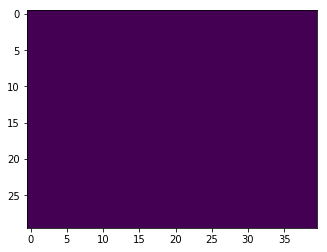

(30, 40)
the correspondence of ( 29 39 ) in image 1. [ 29 39 :,:]


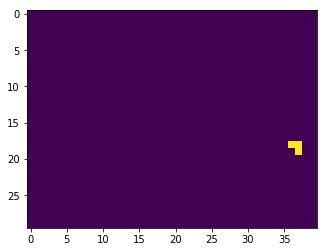

(30, 40)
the correspondence of ( 29 0 ) in image 1. [ 29 0 :,:]


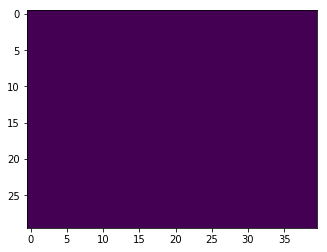

(30, 40)
the correspondence of ( 0 39 ) in image 1. [ 0 39 :,:]


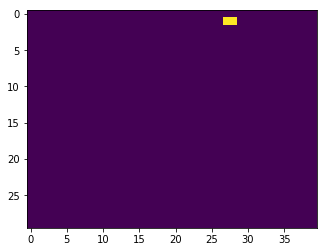

(30, 40)
the correspondence of ( 15 20 ) in image 1. [ 15 20 :,:]


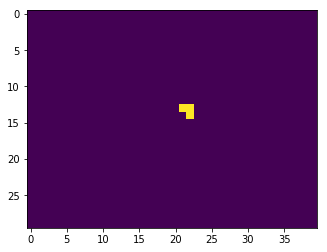

In [105]:
print("mask_o: ", mask_o.shape)
plot_mask_corr(mask_o, 0,0)
plot_mask_corr(mask_o, height-1,width-1)
plot_mask_corr(mask_o, height-1,0)
plot_mask_corr(mask_o, 0,width-1)
plot_mask_corr(mask_o, height//2,width//2)

sum up dim1 and dim2. should look like warping


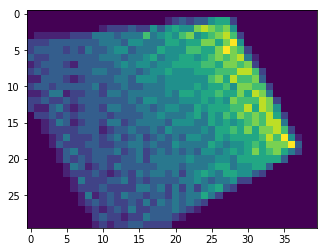

(30, 40)
the correspondence of '0,0', in warped image. [30,40,y,x]


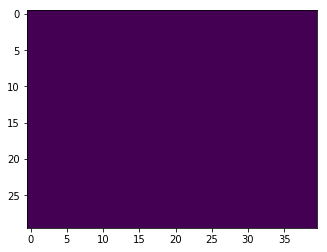

sum up dim3 and dim4. should look like all ones


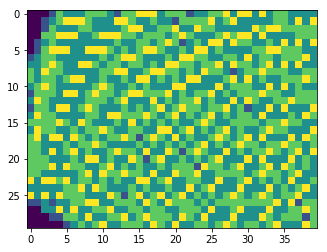

In [106]:
# 
mask_o = mask.sum(dim=1).sum(dim=1)
img = (mask_o).cpu().numpy()[0,:,:]
print("sum up dim1 and dim2. should look like warping")

pltImshow(img)
# 
y, x = 1, 5
img = (mask).cpu().numpy()[0,:,:,y,x]
print(img.shape)
print("the correspondence of '0,0', in warped image. [30,40,y,x]")
pltImshow(img)

# 
mask_o = mask.sum(dim=3).sum(dim=3)
img = (mask_o).cpu().numpy()[0,:,:]
print("sum up dim3 and dim4. should look like all ones")

pltImshow(img)

In [ ]:
warped_descriptors_np = np.random.rand(1,30,40,256)
warped_descriptors_np.dtype

In [ ]:
img.min()